In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11.0, 9.0)
%matplotlib inline

In [38]:
train = pd.read_csv('training.csv', low_memory=False)
test = pd.read_csv('predict.csv', low_memory=False)

In [39]:
# dividing into numerical and categorical 
cat = train.select_dtypes(include=['object'])
num = train.select_dtypes(exclude=['object'])

In [40]:
# deleting unnecessary features (id numbers and lead and order)
num.drop(["id", "owner_id", "poster_id", "participant1_id", "participant2_id", 
          "participant3_id", "participant4_id", "participant5_id", "poster_order", 
          "poster_is_lead", "participant1_is_lead", "participant1_order",
          "participant2_is_lead", "participant2_order", "participant3_is_lead", 
          "participant3_order", "participant4_is_lead", "participant4_order",
          "participant5_is_lead", "participant5_order"], axis=1, inplace=True)

In [41]:
data = [train, test]

In [42]:
train.shape, test.shape

((9418, 72), (100, 71))

In [7]:
train.columns

Index(['id', 'posted_time', 'updated_time', 'age', 'updated_age', 'app_type',
       'owner_id', 'owner_type', 'owner_influence', 'number_of_likes',
       'number_of_comments', 'reactivity', 'is_mentions_me',
       'is_mentions_connections', 'is_commented_by_me',
       'is_commented_by_connections', 'is_liked_by_me',
       'is_liked_by_connections', 'poster_id', 'poster_gender',
       'poster_is_employee', 'poster_is_lead', 'poster_is_in_connections',
       'poster_focus', 'poster_order', 'poster_influence', 'participant1_id',
       'participant1_action', 'participant1_gender',
       'participant1_is_employee', 'participant1_is_lead',
       'participant1_is_in_connections', 'participant1_focus',
       'participant1_order', 'participant1_influence', 'participant2_id',
       'participant2_action', 'participant2_gender',
       'participant2_is_employee', 'participant2_is_lead',
       'participant2_is_in_connections', 'participant2_focus',
       'participant2_order', 'partici

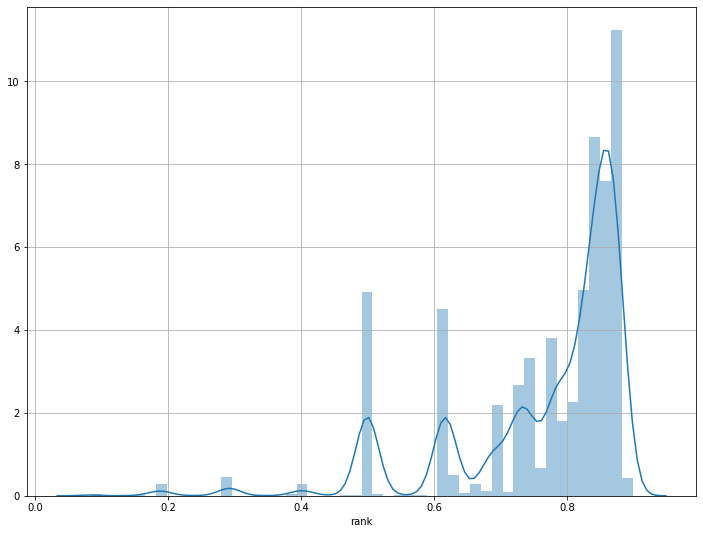

In [7]:
# starting as usual with the target
plt.figure(figsize=(12, 9))
sns.distplot(train['rank'])
plt.grid()

In [8]:
train['rank'].describe()

count    9418.000000
mean        0.765653
std         0.130952
min         0.083330
25%         0.721930
50%         0.821200
75%         0.854960
max         0.897890
Name: rank, dtype: float64

#### 75% of the data is high-ranked  (we also see it on the plot above)

In [9]:
train["rank"].skew() # left hand skewness

-1.69852541349085

### Skewness

In [10]:
# skewness for numerical features
from scipy.stats import skew 
skewness = num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

number_of_comments                18.320102
is_mentions_me                    16.312248
is_commented_by_me                 7.653239
is_liked_by_me                     5.171519
number_of_likes                    3.112263
is_mentions_connections            1.812307
age                                0.957541
reactivity                         0.830732
participant5_is_employee           0.819263
updated_age                        0.624623
participant4_is_employee           0.512073
participant5_influence             0.406560
participant3_is_employee           0.169645
participant4_influence             0.055419
is_commented_by_connections        0.024211
participant2_is_employee          -0.137508
participant1_is_employee          -0.351894
participant3_influence            -0.354293
updated_time                      -0.624625
is_liked_by_connections           -0.636469
participant2_influence            -0.822908
poster_is_employee                -0.932553
posted_time                     

### Feature Correlation

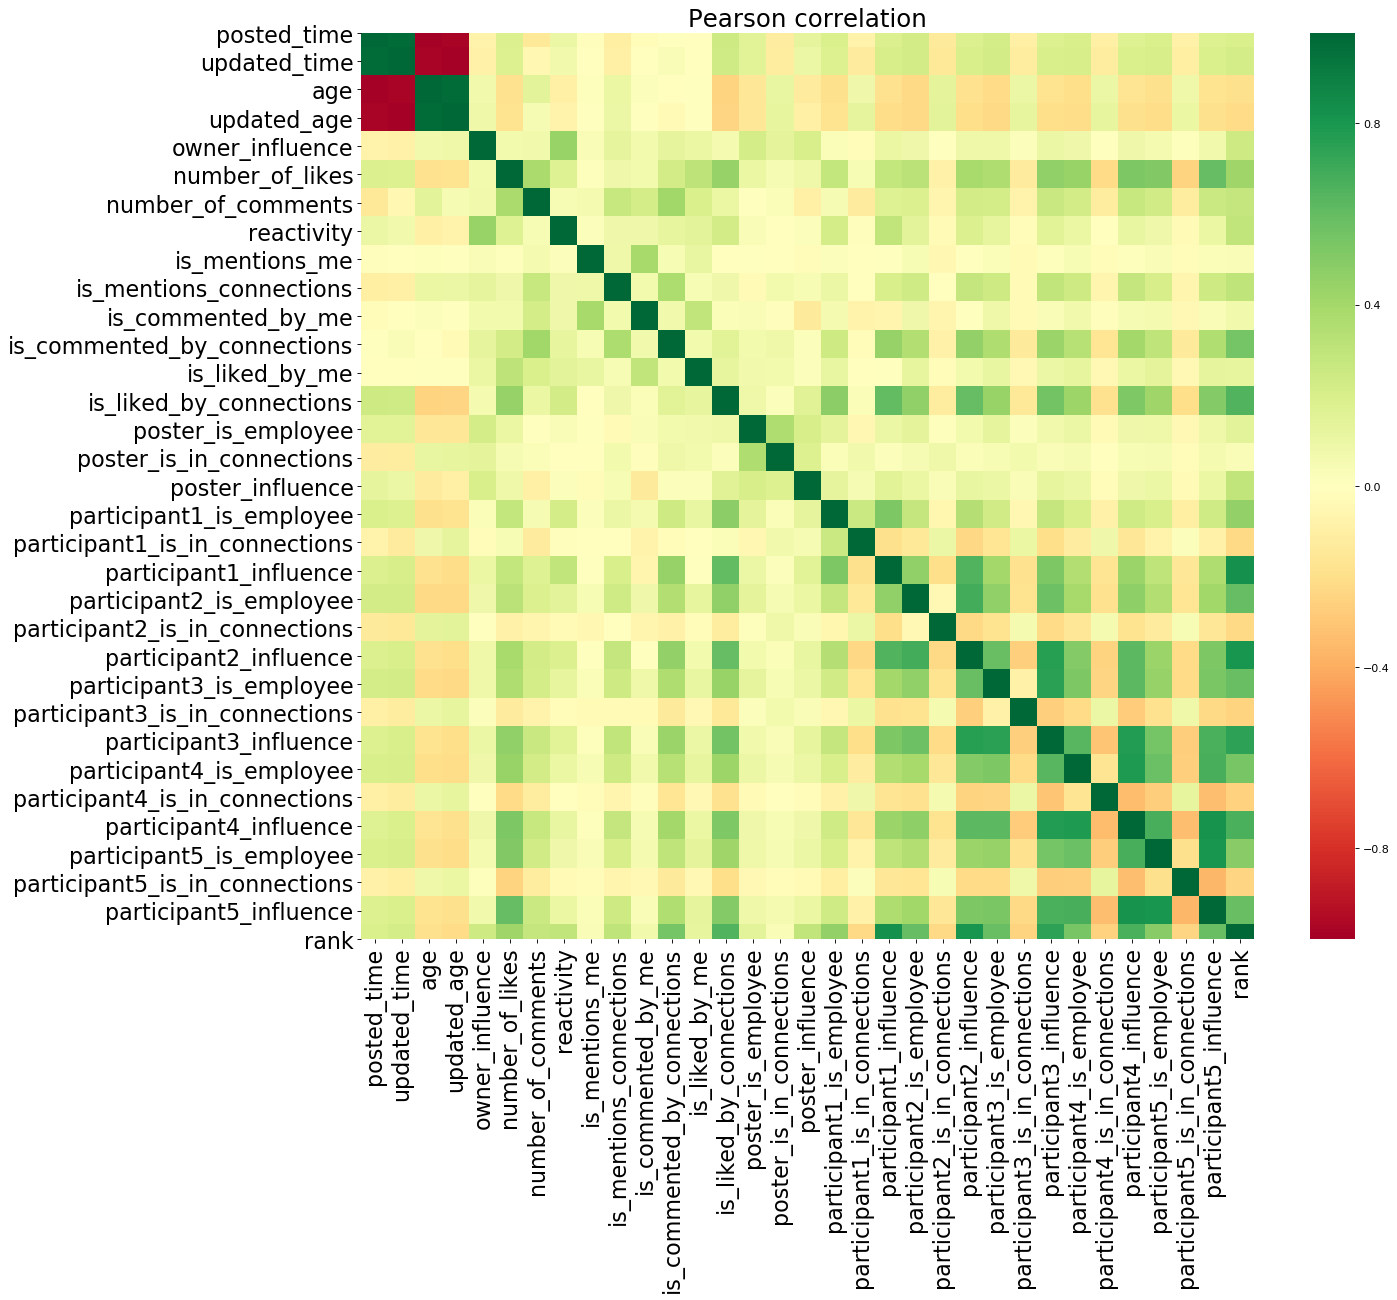

In [14]:
# Person correlation map
plt.figure(figsize=(18,15), dpi= 80)
pearson = num.corr(method = 'pearson')
sns.heatmap(pearson, xticklabels=num.corr().columns, yticklabels=num.corr().columns, cmap='RdYlGn', center=0)
plt.title('Pearson correlation', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### The first thing that we see is something strange at the upper left corner (id and age section). The second are white lines, that do not give us anything (correlation of 0 value). 
#### Generally we see the dark green cells - most correlated features. 
#### Among them are:
#### - is_liked_by_connections & participantN_influence
#### - is_liked_by_connections & rank
#### - participantN_influence  & rank (specifically 1,2,3 participants is darker than 4,5)
#### - is_liked_by_connections & rank
#### - participant1_influence & participant2_influence (less for 3,4,5 participants)
#### - participant2_influence & participant3_influence (again less for 4 and 5)
#### - participant3_influence & participant4_influence (less for 5)
#### - participant4_influence & participant5_influence 
#### - participantN_influence & is_emploee (especially for 4 and 5)
#### - is_commented_by_connections & rank

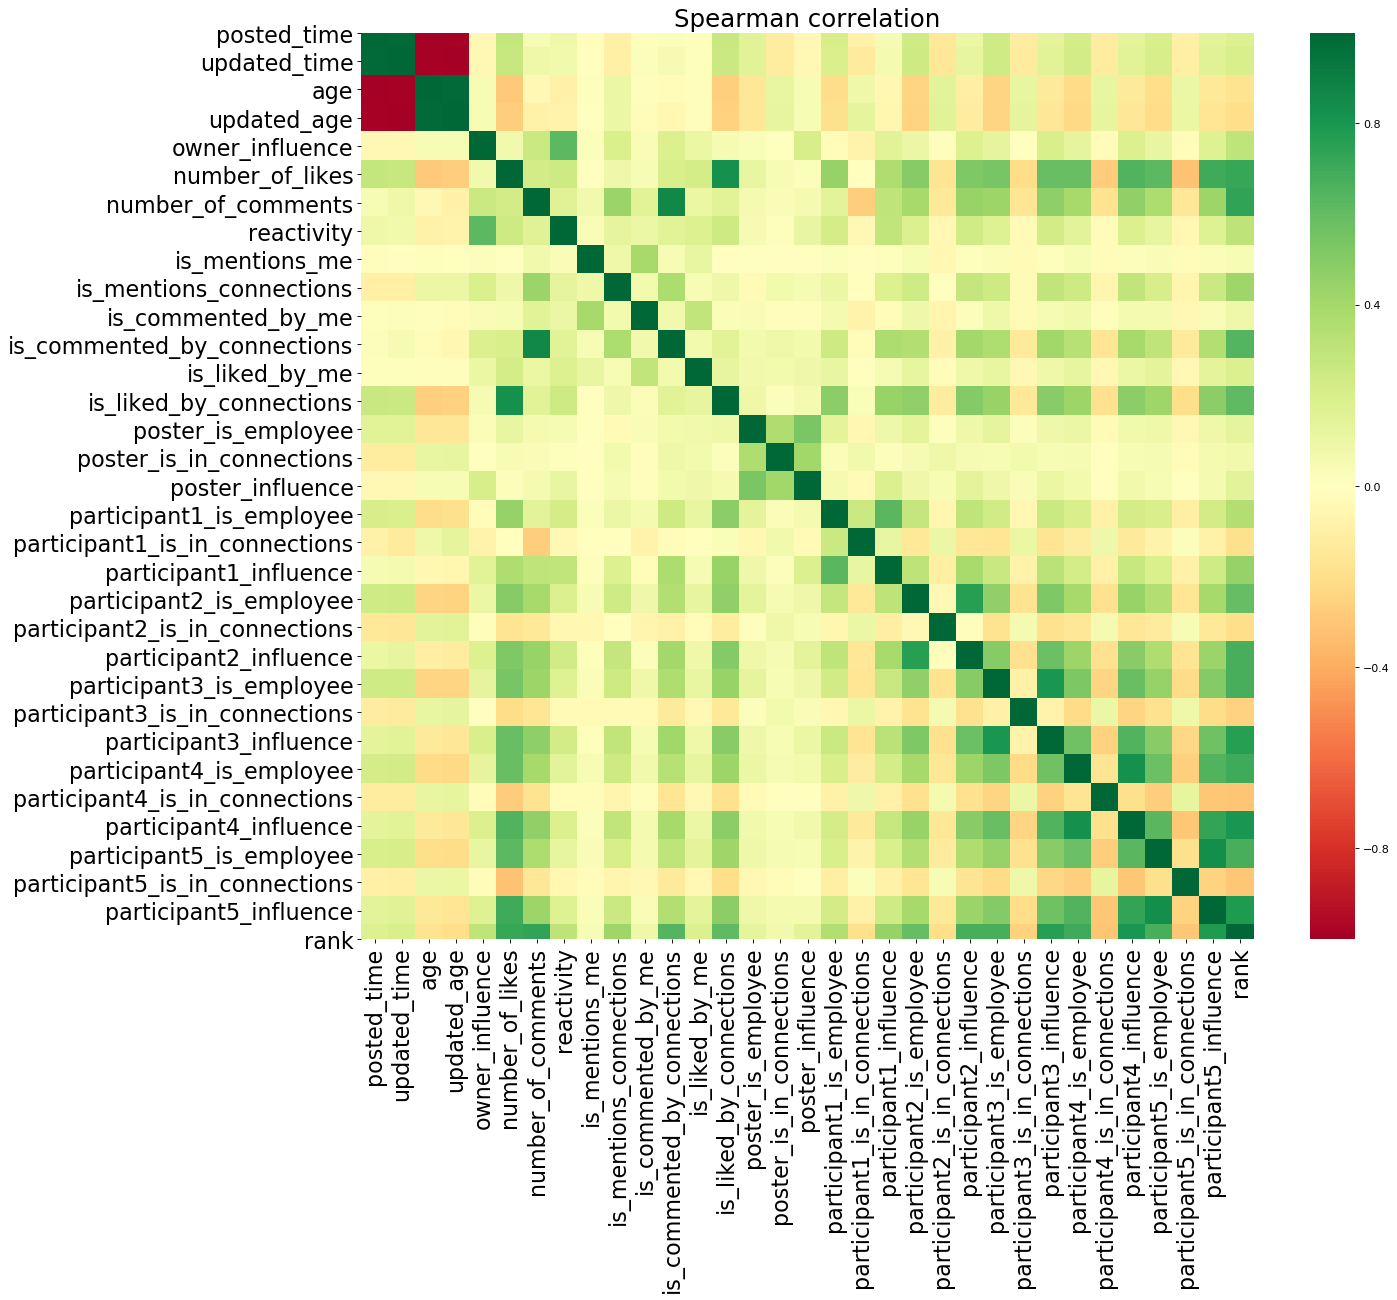

In [15]:
# Person correlation map
plt.figure(figsize=(18,15), dpi= 80)
pearson = num.corr(method = 'spearman')
sns.heatmap(pearson, xticklabels=num.corr().columns, yticklabels=num.corr().columns, cmap='RdYlGn', center=0)
plt.title('Spearman correlation', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### Some new combinations (parametric relationship) are:
#### - is_commented_by_connections & number_of_comments
#### - is_liked_by_connections & number_of_likes
#### - number_of_likes (important for rank)
#### - number_of_comments (important for rank)
#### - number_of_likes & participantN_influence (greener for 3, 4, 5)
#### - participantN_is_emploee & participantN_influence (participant 1 is lighter than others)
#### - reactivity & owner_influence

### Now let's analyze categorical features

/Users/lenasoroka/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


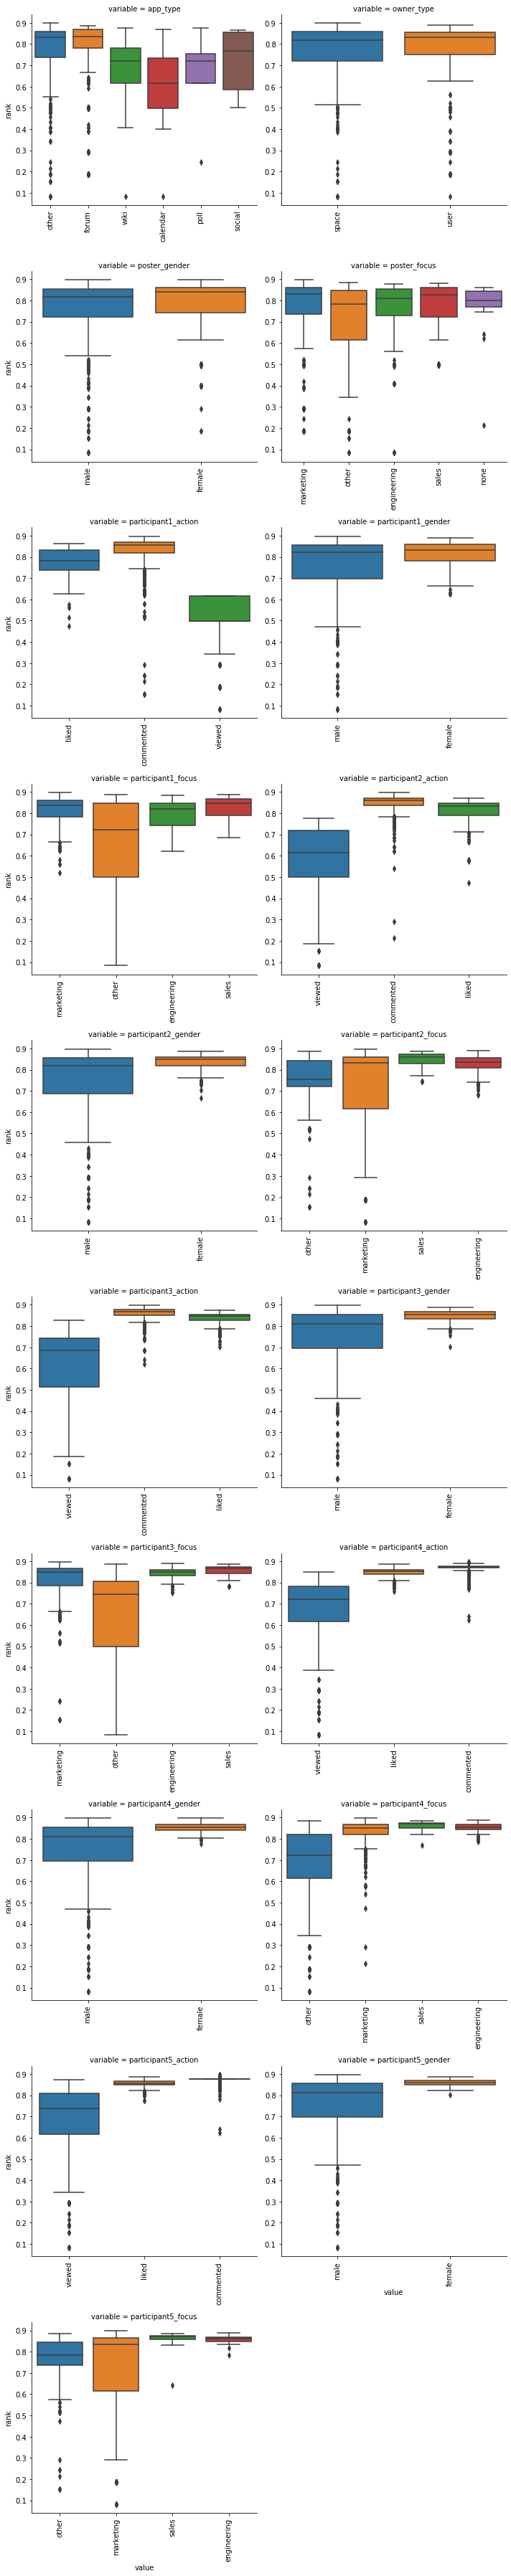

In [15]:
# analyzing all categorical variable using boxplots
categ = [c for c in train.columns if train[c].dtypes == 'object']
def boxplot(x, y, **kwargs):
    sns.boxplot(x = x, y = y)
    x = plt.xticks(rotation=90)
    
pivot = pd.melt(train, id_vars='rank', value_vars = categ)
grid = sns.FacetGrid(pivot, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
grid = grid.map(boxplot, 'value', 'rank')
grid

#### Most of values are high-ranked. Also we see what is more interesting to each participant by it's Focus, 'other' and 'marketing' areas are the most attractive.

### Age solution

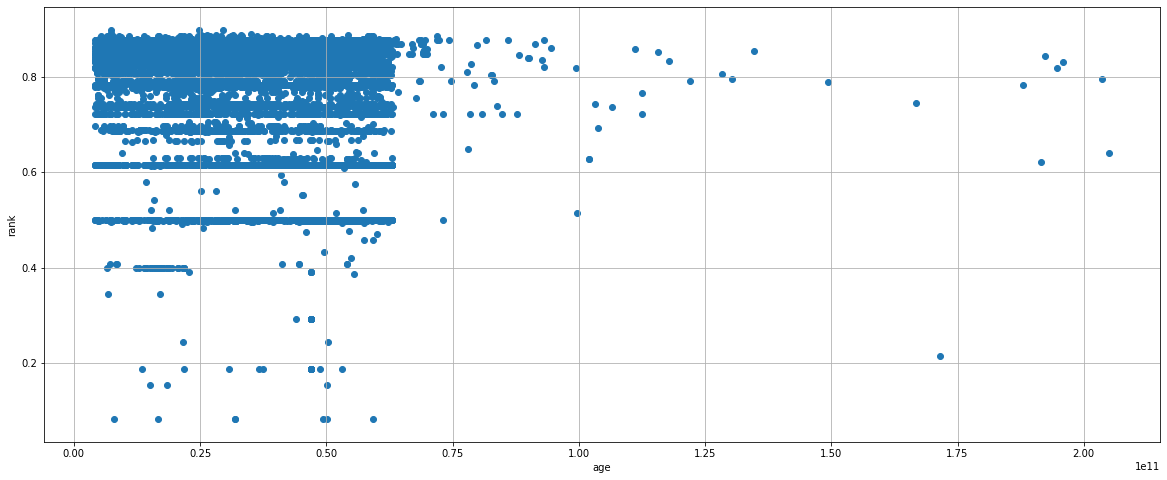

In [92]:
plt.figure(figsize = (20,8))
plt.scatter(train['age'], train['rank'])
plt.xlabel('age')
plt.ylabel('rank')
plt.grid()
plt.show()

In [17]:
train["age"].describe()

count    9.418000e+03
mean     3.393422e+10
std      1.738314e+10
min      4.147070e+09
25%      2.108517e+10
50%      3.214917e+10
75%      4.719412e+10
max      2.050660e+11
Name: age, dtype: float64

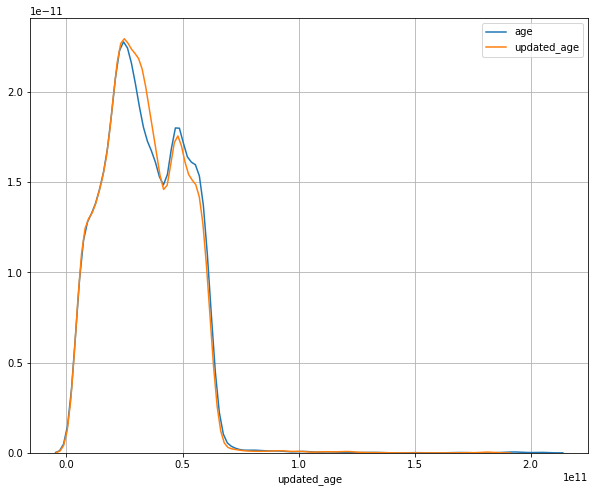

In [55]:
plt.figure(figsize=(10, 8))
sns.distplot(train['age'], hist=False, label='age')
sns.distplot(train['updated_age'], hist=False, label='updated_age')
plt.grid()

plt.show()

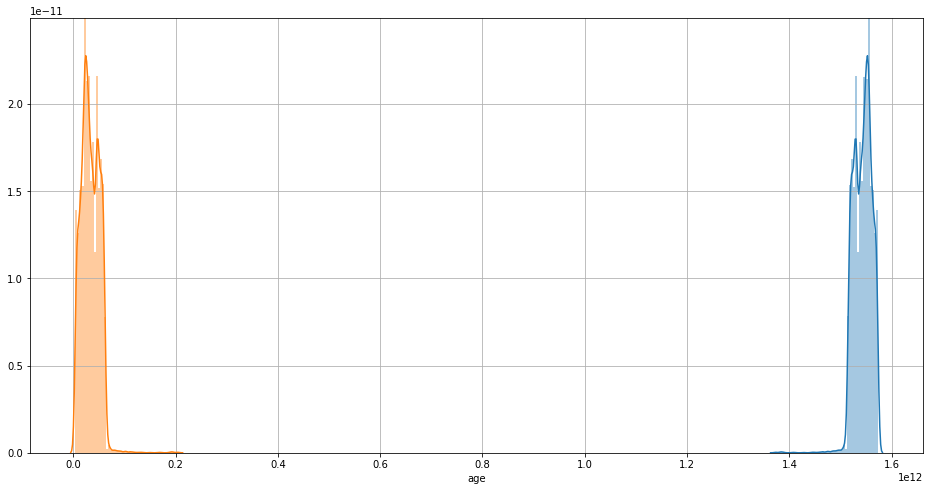

In [8]:
plt.figure(figsize=(16, 8))
sns.distplot(train['posted_time'], label = 'posted_time')
sns.distplot(train['age'], label='age')
plt.grid()
plt.show()

### Fresh news analysis

In [43]:
# as min(age) = 4.147070e+09 ~ 48 days
#fresh = train[(train['age'] <= 4950000000)] # getting fresh news (aproximately 57 days) 
fresh = train[(train['age'] <= 6000000000)]  # getting more than 57 days

In [44]:
fresh.age.describe()

count    2.400000e+02
mean     5.070148e+09
std      5.688204e+08
min      4.147070e+09
25%      4.587234e+09
50%      5.185189e+09
75%      5.534741e+09
max      5.990009e+09
Name: age, dtype: float64

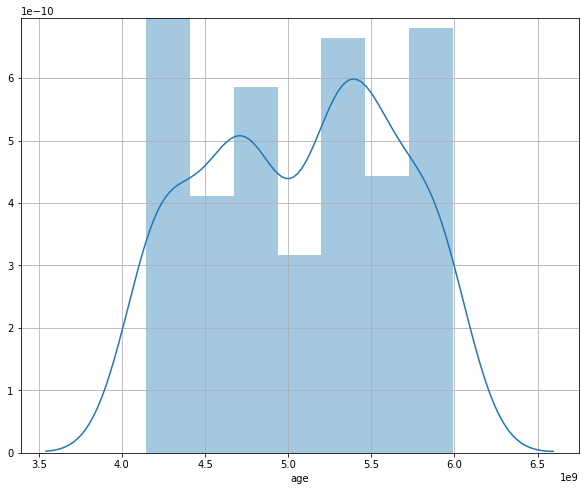

In [9]:
plt.figure(figsize=(10, 8))
sns.distplot(fresh['age'], label='age')
plt.grid()
plt.show()

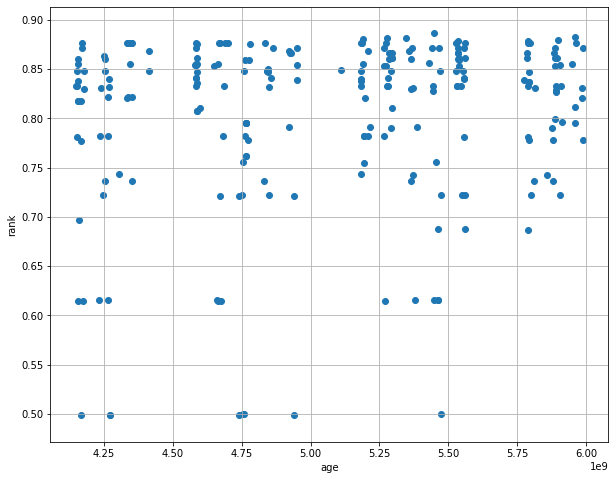

In [45]:
plt.figure(figsize = (10,8))
plt.scatter(fresh['age'], fresh['rank'])
plt.xlabel('age')
plt.ylabel('rank')
plt.grid()
plt.show()

### 2 days = 0.1728e9 ms

In [12]:
fresh.loc[(fresh['age'] > 4.413e9) & (fresh['age'] <= 4.581e9)]

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,...,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
9352,268719,1.572630e+12,1.572630e+12,4.580398e+09,4.580398e+09,other,122534,user,0.96364,13,...,146,liked,male,1,0,1,marketing,1,0.99899,0.85447
9358,268750,1.572790e+12,1.572790e+12,4.413067e+09,4.413067e+09,forum,111913,space,0.99977,1,...,17,commented,female,1,0,1,marketing,1,0.99896,0.86803


In [40]:
4.580398e+09 - 4.413067e+09

167331000.0

In [96]:
# sort age by ascending order (from the smallest to the largest)
sorted_df = fresh.sort_values(by=['age'], ascending=True)
sorted_df

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,...,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
9417,269294,1.573060e+12,1.573060e+12,4.147070e+09,4.147070e+09,other,12,user,0.79592,9,...,5,liked,male,1,0,1,marketing,1,0.99962,0.83285
9416,269255,1.573060e+12,1.573060e+12,4.150372e+09,4.150372e+09,other,12,user,0.79592,5,...,75,liked,male,1,0,1,marketing,1,0.99674,0.83259
9415,269249,1.573060e+12,1.573060e+12,4.151101e+09,4.150801e+09,other,57727,space,0.99973,12,...,10,liked,male,1,0,1,marketing,1,0.99902,0.84820
9411,269242,1.573050e+12,1.573050e+12,4.151483e+09,4.151483e+09,other,12,user,0.79592,3,...,3080,viewed,male,0,0,1,marketing,1,0.23077,0.78110
9408,269214,1.573050e+12,1.573050e+12,4.153998e+09,4.153998e+09,other,99314,user,0.10000,4,...,128564,liked,male,1,0,0,other,1,0.97487,0.86040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142,266467,1.571240e+12,1.571240e+12,5.965104e+09,5.964875e+09,other,57727,space,0.99973,4,...,119825,commented,female,1,0,0,other,1,0.99754,0.87640
9138,266432,1.571220e+12,1.571220e+12,5.984333e+09,5.984333e+09,forum,111913,space,0.99977,0,...,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82107
9137,266422,1.571220e+12,1.571220e+12,5.986430e+09,5.986430e+09,other,78,user,0.99937,4,...,22636,viewed,male,0,0,1,other,1,0.23077,0.83023
9134,266409,1.571220e+12,1.571220e+12,5.989643e+09,5.989643e+09,other,57727,space,0.99973,2,...,44661,viewed,male,0,0,1,other,1,0.23077,0.77768


#### Here is idea of shifting age when there is 2 days empty space between points

In [97]:
def shift(column):
    age = column.to_list()
    for i in range(len(age)):
        if i != len(age) - 1:
            if (age[i + 1] - age[i]) > 150000000.0:
                age[i+1:] = [(element - 149000000.0) for element in age[i+1:]]
                
    return age

sorted_df['new_age'] = shift(sorted_df['age'])

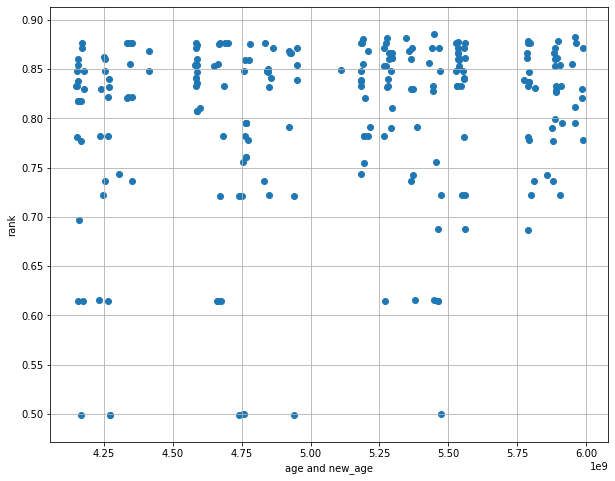

In [86]:
plt.figure(figsize = (10,8))
plt.scatter(fresh['age'], fresh['rank'])
#plt.scatter(sorted_df['age'], sorted_df['rank'])
plt.xlabel('age and new_age')
plt.ylabel('rank')
plt.grid()
plt.show()

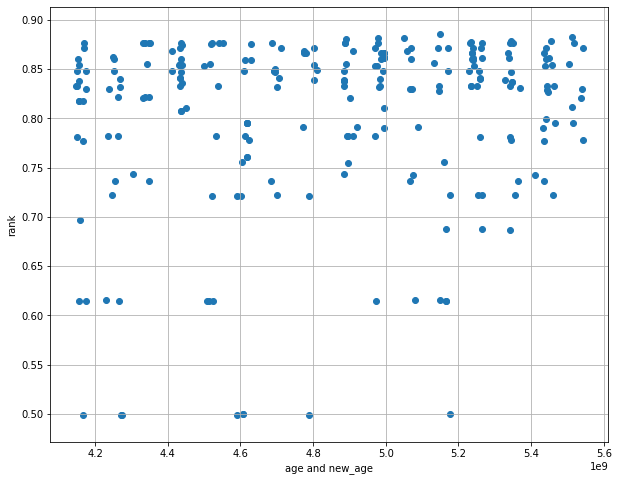

In [98]:
plt.figure(figsize = (10,8))
#plt.scatter(fresh['age'], fresh['rank'])
plt.scatter(sorted_df['new_age'], sorted_df['rank'])
plt.xlabel('age and new_age')
plt.ylabel('rank')
plt.grid()
plt.show()

### Old analysis of effective age (from the last week)

In [93]:
train['effective_age'] = np.log(train['age']) * (10 ** 9) 

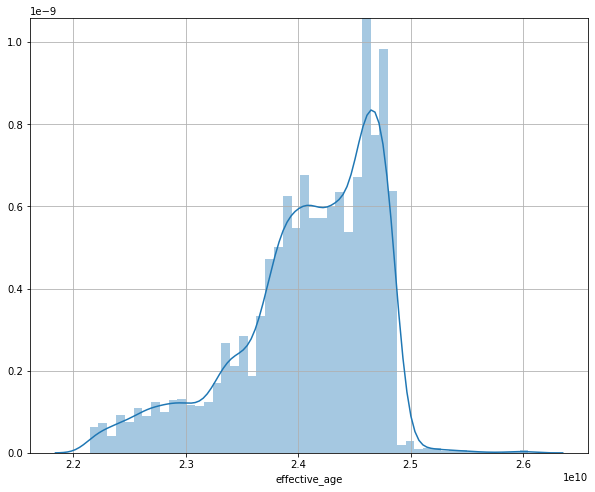

In [94]:
plt.figure(figsize=(10, 8))
sns.distplot(train['effective_age'])
plt.grid()
plt.show()

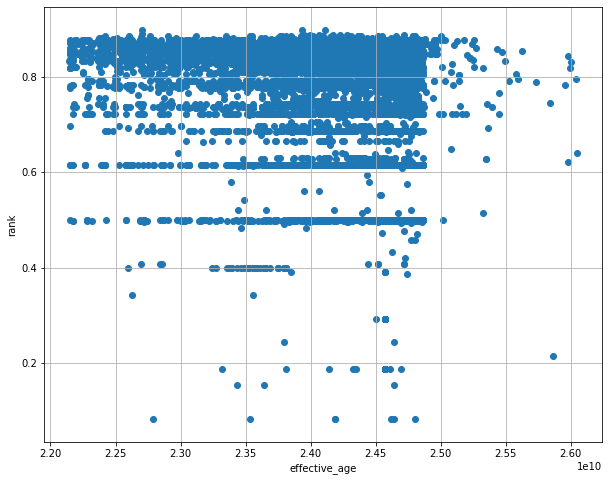

In [95]:
plt.figure(figsize = (10,8))
plt.scatter(train['effective_age'], train['rank'])
plt.xlabel('effective_age')
plt.ylabel('rank')
plt.grid()
plt.show()